<a href="https://colab.research.google.com/github/marendtz/News_NER/blob/master/XLMR_pan_and_custom_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preparations**

In [2]:
# for debugging: clean up model
import shutil
try:
  shutil.rmtree('/content/maren-hugg/xlm-roberta-base-finetuned-panx-en-news')
except:
  print("no such folder")

no such folder


In [3]:
# get github access token for collab
import getpass
token = getpass.getpass()

··········


In [4]:
# clean workdir
%cd /content/
%rm -r /content/*
%ls -la
%pwd

/content
total 16
drwxr-xr-x 1 root root 4096 Apr 30 18:39 ./
drwxr-xr-x 1 root root 4096 Apr 30 18:36 ../
drwxr-xr-x 4 root root 4096 Apr 27 13:34 .config/


'/content'

In [5]:
# clone github repo
!git clone https://{token}@github.com/marendtz/News_NER.git

Cloning into 'News_NER'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 44 (delta 22), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (44/44), 320.31 KiB | 3.24 MiB/s, done.


In [6]:
# install dependencies
%pip install -r /content/News_NER/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6

In [7]:
# import packages
from collections import defaultdict
import pandas as pd
import numpy as np
from datasets import load_dataset_builder, get_dataset_config_names, load_dataset, DatasetDict

from transformers import AutoTokenizer, TrainingArguments, DataCollatorForTokenClassification, Trainer, AutoModelForTokenClassification
import nltk.data
nltk.download('punkt')

import torch.nn as nn
from transformers import XLMRobertaConfig, AutoConfig, XLMRobertaForTokenClassification
from transformers.modeling_outputs import TokenClassifierOutput

from huggingface_hub import notebook_login
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from seqeval.scheme import IOB2


from torch.nn.functional import cross_entropy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Prepare PAN-X test data**

In [8]:
# prepare dataset
panx_ch = defaultdict(DatasetDict)

langs = ["en"] # e.g. ["de","en"]
fracs = [1.0] # e.g. [0.5,0.5]
# panx_ch contains keys for each language and one level lower keys for all splits - here only eng and all data is selected
for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))
print(panx_ch)
print("Example element in Pan-X Dataset:")
panx_ch_element = panx_ch["en"]["test"][123]
for key, value in panx_ch_element.items():
    print(f"{key}: {value}")


Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

defaultdict(<class 'datasets.dataset_dict.DatasetDict'>, {'en': DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})})
Example element in Pan-X Dataset:
tokens: ["'", "''", 'Dobruška', "''", "'", '-']
ner_tags: [0, 0, 5, 0, 0, 0]
langs: ['en', 'en', 'en', 'en', 'en', 'en']


**Prepara Custom test data**

In [9]:
# login to HugginFace to enable upload of model
notebook_login()

**Get tags (index2tag and tag2index) used the same way by both datasets**

In [10]:
# get info from dataset later used for training our model
# load dataset to get the tags used, so we later take the same...
lang = "en"
ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
tags = ds["train"].features["ner_tags"].feature
print(tags)

# generate function to convert name and id of tags
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
print(index2tag)
print(tag2index)
     

  0%|          | 0/3 [00:00<?, ?it/s]

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


In [11]:
ds_custom = load_dataset("maren-hugg/news_ner_dict")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/maren-hugg___parquet/maren-hugg--news_ner_dict-912bfa5b6de7e043/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

**Set tokenizer and model**

In [12]:
# setup for tokenization
xlmr_model_name = "maren-hugg/xlm-roberta-base-finetuned-panx-en-news"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)
xlmr_model = AutoModelForTokenClassification.from_pretrained(xlmr_model_name)

**Define helper function for data preparation**

In [13]:
# the library datasets provides a fast way to tokenize dataset objects with the map() operation.
# the returned input ids need to be augmented with the attention mask and the label ids, that encode the information about with token is associated with each NER tag

def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)  # sequence is already split in words
  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx) # get word ids to associate subwords
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100) # -100 is chose, since the PyTorch cross-entropy loss class torch.nn.CrossEntropyLoss has an attribute ignore_index, whose value is -100, which is therefor ignored during training
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,remove_columns=['langs', 'ner_tags', 'tokens'])

def encode_custom_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,remove_columns=['ner_tags', 'tokens'])



**Encode both test datasets**

In [14]:
# encode PAN-X dataset
panx_en_encoded = encode_panx_dataset(panx_ch["en"])
print("Encoded example:")
print(panx_en_encoded["test"][2])

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Encoded example:
{'input_ids': [0, 14851, 4097, 70, 54336, 144593, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 1, -100, 2, 2, -100, -100]}


In [15]:
# encode Custom dataset
ds_custom_encoded = encode_custom_dataset(ds_custom)
print("Encoded example:")
print(ds_custom_encoded["test"][0])

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Encoded example:
{'input_ids': [0, 108725, 1927, 13, 442, 25, 7, 2965, 23, 102126, 678, 70, 53702, 108725, 9, 60785, 254, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 3, 0, -100, 0, -100, -100, 0, 0, 5, 0, 0, 0, 3, -100, -100, -100, 0, -100, -100]}


**Define performance measures**

In [16]:
# common approach: results for precision, recall, F1-score
# in NER: all words of an entity need to be predicted correctly in order for a prediction to be counted as correct
# libary seqeval: expects predictions and labels as lists of lists 



# during training we need to convert the outputs of the model into such a list that sequeval expects
def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return preds_list, labels_list

# helper function for calculation of F1-score for validation set
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred),
          "precision": precision_score(y_true, y_pred),
          "recall": recall_score(y_true, y_pred),
          "accuracy": f1_score(y_true, y_pred),
          "classification_report": classification_report(y_true, y_pred, mode='strict', scheme=IOB2, output_dict=True)
          }


**Setup Trainer that will be used for making predictions**

In [17]:
# hide_output

import torch

# passing keyword arguments to the from_pretrained() method overrides default values
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)

# define "device"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [18]:
# docu: https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(output_dir="test-trainer",do_train=False, do_eval=False, do_predict=False)

In [19]:
# pad each input sequence to the largest sequence length in a batch
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [20]:
# init method, to avoid initializing a new model for every Trainer (it loads the untrained model and is called at the beginning of the train() call)
def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config=xlmr_config)
          .to(device))

In [21]:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer)

**Make predictions for PAN-X test dataset**

In [22]:
predictions_panx_output = trainer.predict(test_dataset=panx_en_encoded["test"])

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [23]:
#predictions_panx_output.metrics

**Make predictions for Custom test dataset**

In [24]:
predictions_custom_output = trainer.predict(test_dataset=ds_custom_encoded["test"])

**Compare Results of both test sets**

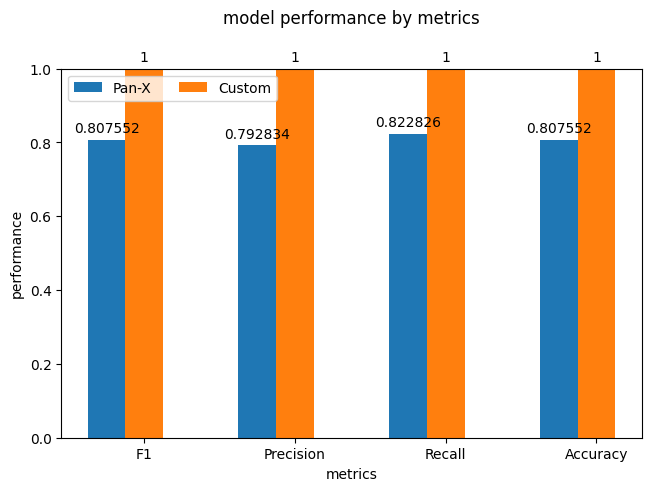

In [25]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ("F1", "Precision",  "Recall", "Accuracy")
model_performance = {
    'Pan-X': (predictions_panx_output.metrics["test_f1"], 
              predictions_panx_output.metrics["test_precision"],
              predictions_panx_output.metrics["test_recall"],
              predictions_panx_output.metrics["test_accuracy"]),
    'Custom': (predictions_custom_output.metrics["test_f1"], 
              predictions_custom_output.metrics["test_precision"],
              predictions_custom_output.metrics["test_recall"],
              predictions_custom_output.metrics["test_accuracy"])
}

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in model_performance.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('performance')
ax.set_xlabel('metrics')
ax.set_title('model performance by metrics', y=1.1)
ax.set_xticks(x + width, metrics)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)


plt.show()

In [26]:
classification_report_panx = pd.DataFrame(predictions_panx_output.metrics["test_classification_report"]).transpose().drop(['PER'])

In [27]:
classification_report_custom = pd.DataFrame(predictions_custom_output.metrics["test_classification_report"]).transpose()

In [28]:
classification_report_panx.compare(classification_report_custom, result_names=("PAN-X","Custom"))

precision           recall         f1-score         support  \
                 PAN-X Custom     PAN-X Custom     PAN-X Custom    PAN-X   
LOC           0.811600    1.0  0.859352    1.0  0.834793    1.0   4657.0   
ORG           0.769764    1.0  0.701791    1.0  0.734208    1.0   4745.0   
micro avg     0.818299    1.0  0.821464    1.0  0.819878    1.0  13958.0   
macro avg     0.816922    1.0  0.822839    1.0  0.818994    1.0  13958.0   
weighted avg  0.816245    1.0  0.821464    1.0  0.817961    1.0  13958.0   

                     
             Custom  
LOC             1.0  
ORG             2.0  
micro avg       3.0  
macro avg       3.0  
weighted avg    3.0

**Do specific loss evaluation**

In [29]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # Convert dict of lists to list of dicts suitable for data collator
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  # Pad inputs and labels and put all tensors on device
  batch = data_collator(features)
  input_ids = batch["input_ids"].to(device)
  attention_mask = batch["attention_mask"].to(device)
  labels = batch["labels"].to(device)
  with torch.no_grad():
    # Pass data through model
    output = trainer.model(input_ids, attention_mask)
    # logit.size: [batch_size, sequence_length, classes]
    # Predict class with largest logit value on classes axis
    predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
  # Calculate loss per token after flattening batch dimension with view
  loss = cross_entropy(output.logits.view(-1, 7), 
                       labels.view(-1), reduction="none")
  # Unflatten batch dimension and convert to numpy array
  loss = loss.view(len(input_ids), -1).cpu().numpy()
  return {"loss":loss, "predicted_label": predicted_label}

def create_eval_df(df_encoded_split):
  index2tag[-100] = "IGN"
  # create pd.DaraFrame
  df_for_eval= df_encoded_split.map(forward_pass_with_label, batched=True, batch_size=32)
  df = df_for_eval.to_pandas()

  # prepare df columns
  df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
  df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
  df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
  df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
  df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
  #print(df.head(1))

  # explode to tokens
  df_tokens = df.apply(pd.Series.explode)
  df_tokens = df_tokens.query("labels != 'IGN'")
  df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
  #print(df_tokens.head(7))  
  return df_tokens

In [30]:
# for PAN-X
panx_df_eval = create_eval_df(panx_en_encoded["test"])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

<ipython-input-29-0afc41fed663>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)


In [31]:
# group by input token , aggregate loss and sort by loss
(panx_df_eval.groupby("input_tokens")[["loss"]]
.agg(["count", "mean", "sum"])
.droplevel(level=0, axis=1) # Get rid of multi-level columns
.sort_values(by="sum", ascending=False)
.reset_index()
.round(2)
.head(10)
.T)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁of,▁(,▁),▁the,▁The,▁'',▁and,▁',▁in
count,7636,1858,2583,2571,1619,490,3900,918,1840,1386
mean,0.16,0.38,0.24,0.23,0.23,0.61,0.07,0.28,0.13,0.15
sum,1218.4,712.31,614.8,584.76,370.33,297.18,257.31,252.68,243.18,210.59


In [32]:
# group by labels, aggregate loss
(panx_df_eval.groupby("labels")[["loss"]]
  .agg(["count", "mean", "sum"])
  .droplevel(level=0, axis=1)
  .sort_values(by="mean", ascending=False)
  .reset_index()
  .round(2)
  .T
  )

,0,1,2,3,4,5,6
labels,B-ORG,I-ORG,I-LOC,B-LOC,I-PER,B-PER,O
count,4745,11607,6447,4657,7480,4556,40834
mean,0.9,0.72,0.53,0.39,0.39,0.3,0.04
sum,4247.19,8414.46,3447.01,1829.01,2899.64,1364.01,1567.03


In [33]:
# for Custom dataset
custom_df_eval= create_eval_df(ds_custom_encoded["test"])

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

<ipython-input-29-0afc41fed663>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)


In [34]:
# group by input token , aggregate loss and sort by loss
(custom_df_eval.groupby("input_tokens")[["loss"]]
.agg(["count", "mean", "sum"])
.droplevel(level=0, axis=1) # Get rid of multi-level columns
.sort_values(by="sum", ascending=False)
.reset_index()
.round(2)
.head(10)
.T)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁Adidas,▁,▁Germany,▁best,▁in,▁it,▁organization,▁the,▁tri,▁with
count,2,1,1,1,1,1,1,1,1,1
mean,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# group by labels, aggregate loss
(custom_df_eval.groupby("labels")[["loss"]]
  .agg(["count", "mean", "sum"])
  .droplevel(level=0, axis=1)
  .sort_values(by="mean", ascending=False)
  .reset_index()
  .round(2)
  .T
  )

,0,1,2
labels,B-ORG,B-LOC,O
count,2,1,8
mean,0.01,0.0,0.0
sum,0.02,0.0,0.0


**Normalized Confusion Matrix**

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

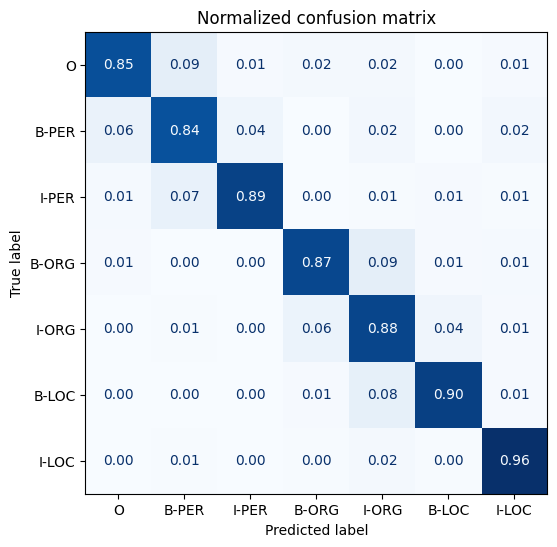

In [37]:
# for PAN-X
plot_confusion_matrix(panx_df_eval["labels"], panx_df_eval["predicted_label"],tags.names)

ValueError: ignored

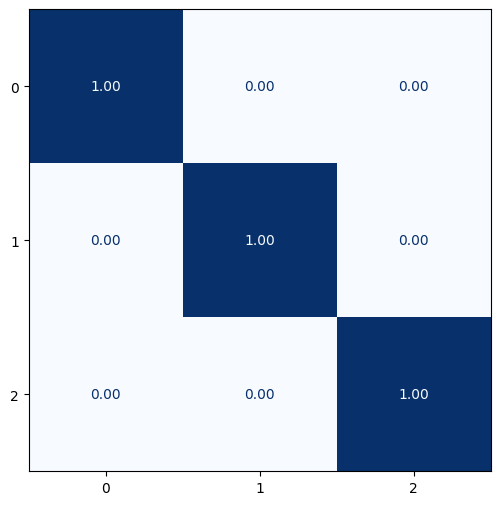

In [38]:
# for Custom
plot_confusion_matrix(custom_df_eval["labels"], custom_df_eval["predicted_label"],tags.names)